# Instalación e Importación de Librerías

In [2]:
! pip install sqlalchemy==1.4.46
! pip install pandasql==0.7.3


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sys
import os
sys.path.append(".")
import pandas as pd
import pandasql as ps
from datetime import timedelta
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

# Lectura de archivos

## Lectura Dataset de Bombas

In [4]:
df_bombs = pd.read_csv('data/csv/Dataset_Bombes_2020-23.csv', delimiter=';', encoding='latin-1')
df_bombs['dhIni'] = pd.to_datetime(df_bombs['dhIni'], format='%Y-%m-%d %H:%M:%S.%f')
df_bombs['dhFin'] = pd.to_datetime(df_bombs['dhFin'], format='%Y-%m-%d %H:%M:%S.%f')
df_bombs['Orden'] = df_bombs['Orden'].fillna(0).astype(int)

print(df_bombs.shape)
print(df_bombs.dtypes)
df_bombs.head()

(120978, 17)
Orden                           int32
CodMaterial                    object
DescMaterial                   object
maquina_dsc                    object
QtyPlan                       float64
QtyBuenas_Total               float64
QtyMalas_Total                float64
CantidadBuenas                float64
CantidadMalas                 float64
dhIni                  datetime64[ns]
dhFin                  datetime64[ns]
T_Diff [s]                    float64
IncidName                      object
Observaciones                  object
TiempoTeorico [min]            object
OperariosEnMaq                float64
OperIds                        object
dtype: object


,Orden,CodMaterial,DescMaterial,maquina_dsc,QtyPlan,QtyBuenas_Total,QtyMalas_Total,CantidadBuenas,CantidadMalas,dhIni,dhFin,T_Diff [s],IncidName,Observaciones,TiempoTeorico [min],OperariosEnMaq,OperIds
0,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:20.250,2020-01-02 05:53:50.063,30.000,Produccion,NaN,85,1.0,5025
1,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:50.063,2020-01-02 05:54:08.010,18.000,Produccion,NaN,85,1.0,5025
2,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:54:08.010,2020-01-02 08:49:39.577,10.531,Produccion,NaN,85,1.0,5025
3,5160396,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 08:49:39.577,2020-01-02 08:59:16.247,577.000,Produccion,NaN,85,1.0,5025
4,5165729,01224-0890,B.CENT.20CV 400/690 1450 S/PR,LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2020-01-02 08:59:48.200,2020-01-02 09:02:40.420,172.000,Produccion,NaN,"85,58",1.0,5025


## Lectura Dataset Defectuosas Interna

In [5]:
df_defective = pd.read_csv('data/csv/Defectuositat_Interna_2020-23.csv', delimiter=';', encoding='latin-1')[:-3]
df_defective['Jornada'] = pd.to_datetime(df_defective['Jornada'], format='%d-%m-%y')
print(df_defective.shape)
print(df_defective.dtypes)
df_defective.head()


(1853, 15)
Jornada       datetime64[ns]
Maq.                  object
OF                   float64
Descripció            object
Item                  object
Component             object
Qty                  float64
T.I.                  object
Motiu                 object
Decisió               object
Units FR             float64
Qty. Fab.            float64
Q.F./Dia             float64
FR                    object
FR/Dia                object
dtype: object


,Jornada,Maq.,OF,Descripció,Item,Component,Qty,T.I.,Motiu,Decisió,Units FR,Qty. Fab.,Q.F./Dia,FR,FR/Dia
0,2023-01-04,LINEA 3,5373418.0,BOMBA VERDON ES 075M,73678,73678-0475,NaN,G,DAÑOS O GOLPES,Destruir,NaN,408.0,NaN,NaN,NaN
1,2023-01-04,LINEA 4,5372007.0,B.A.SENA 33M,25461,25461-0300,NaN,R,ROSCADO EJE MOTOR N/OK,Destruir,NaN,192.0,NaN,NaN,NaN
2,2023-01-04,LINEA 4,5372007.0,B.A.SENA 33M,25461,25461-9601F,NaN,G,FUGAS CIERRE MECÁNICO,Recuperable In Situ,NaN,192.0,NaN,NaN,NaN
3,2023-01-03,LÍNEA KIVU,5371822.0,BOMBA KIVU 4HP 400/6,63043-0890,72A4000075,NaN,G,DAÑOS O GOLPES,Destruir,NaN,6.0,NaN,NaN,NaN
4,2023-01-02,LÍNEA 2,5371351.0,BOMBA V.PLUS SILENT,65562,77C2000064,NaN,G,MONTAJE JUNTA N/OK,Recuperable In Situ,NaN,792.0,NaN,NaN,NaN


## Información Relevante de Bombas

In [6]:
df_exp = df_bombs['OperIds'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('OperIds')

In [7]:
print(f"""Resumen información relevante sobre el Dataset de bombas:
--> Cantidad de Órdenes de fabicación: {df_bombs['Orden'].nunique()}
--> Cantidad de distintos materiales: {df_bombs['CodMaterial'].nunique()}
--> Cantidad de lineas/máquinas: {df_bombs['maquina_dsc'].nunique()}
--> Cantidad máxima registrada de operarios en máquinas: {df_bombs['OperariosEnMaq'].max()}
--> Cantidad de operarios distintos que trabajan en la planta: {df_exp['OperIds'].nunique()}

--> Fecha más antigua de registros: {df_bombs['dhIni'].min()}
--> Fecha más nueva de registros: {df_bombs['dhFin'].max()}    
""")

Resumen información relevante sobre el Dataset de bombas:
--> Cantidad de Órdenes de fabicación: 5555
--> Cantidad de distintos materiales: 724
--> Cantidad de lineas/máquinas: 10
--> Cantidad máxima registrada de operarios en máquinas: 8.0
--> Cantidad de operarios distintos que trabajan en la planta: 117

--> Fecha más antigua de registros: 2020-01-02 05:49:27.273000
--> Fecha más nueva de registros: 2023-02-13 13:30:36.823000    



### Revisión de casos Diff cero

In [8]:
print(df_bombs[df_bombs['T_Diff [s]'] <= 0]['Orden'].unique())
df_bombs[df_bombs['T_Diff [s]'] <= 0]['Orden'].nunique()

[5263472 5273225 5275960 5253657 5268390 5288629 5180777 5174432 5191685
 5204678 5231555 5235176 5235172 5242037 5241538 5254555 5260963 5253757
 5261566 5267248 5257965 5256172 5265480 5265141 5267945 5255357 5273559
 5269799 5271241 5271239 5269098 5263885 5273869 5269801 5274186 5261568
 5276600 5274189 5273874 5274188 5281115 5281112 5281383 5287266 5271238
 5272862 5280384 5279750 5276295 5278425 5266757 5278420 5279741 5281111
 5282399 5278101 5286927 5286654 5292715 5277735 5282392 5282397 5292409
 5292408 5289828 5278864 5280048 5295482 5280388 5295485 5292718 5293107
 5292717 5295268 5279198 5297069 5300944 5288215 5297071 5299075 5293349
 5298783 5302107 5298199 5295267 5305865 5288214 5293108 5304372 5298785
 5293109 5298791 5305922 5298787 5305904 5307933 5310395 5306215 5308586
 5303175 5326003 5306488 5335182 5331285 5334829 5349039 5319698 5364004
 5172848 5177081 5205792 5227778 5288639 5297584 5295741 5318366 5324697
 5323857 5174138 5201582 5252691 5262185 5263883 52

149

In [9]:
df_bombs[(df_bombs['T_Diff [s]'] <= 0) & (df_bombs['CantidadBuenas'] != 0)]['Orden'].unique()

array([5253657, 5288629, 5261566, 5267248, 5257965, 5256172, 5265480,
       5265141, 5255357, 5274189, 5273874, 5274188, 5281115, 5281112,
       5271238, 5272862, 5280384, 5279750, 5276295, 5278425, 5266757,
       5278420, 5279741, 5281111, 5282399, 5278101, 5286927, 5286654,
       5292715, 5277735, 5282392, 5282397, 5292409, 5292408, 5289828,
       5278864, 5280048, 5295482, 5280388, 5295485, 5293107, 5292717,
       5295268, 5279198, 5297069, 5300944, 5288215, 5297071, 5299075,
       5293349, 5298783, 5302107, 5298199, 5295267, 5305865, 5288214,
       5293108, 5304372, 5298785, 5293109, 5298791, 5305922, 5298787,
       5305904, 5310395, 5303175, 5297584, 5295741, 5262185, 5263883,
       5281110, 5265473, 5276292, 5288137, 5282079, 5296682, 5259363,
       5314001, 5313918, 5313939, 5313915, 5316225, 5313928, 5327336,
       5319855, 5327338, 5324767, 5333201, 5324791, 5332532])

### Agrupación por Orden de fabricación

In [10]:
df_bombs.dtypes

Orden                           int32
CodMaterial                    object
DescMaterial                   object
maquina_dsc                    object
QtyPlan                       float64
QtyBuenas_Total               float64
QtyMalas_Total                float64
CantidadBuenas                float64
CantidadMalas                 float64
dhIni                  datetime64[ns]
dhFin                  datetime64[ns]
T_Diff [s]                    float64
IncidName                      object
Observaciones                  object
TiempoTeorico [min]            object
OperariosEnMaq                float64
OperIds                        object
dtype: object

In [18]:
df_bombs_grouped = df_bombs.groupby(
        ['Orden', 'CodMaterial', 'maquina_dsc']
    ).agg(
        QtyPlan=('QtyPlan', 'max'),
        QtyBuenas_Total=('QtyBuenas_Total', 'max'),
        QtyMalas_Total=('QtyMalas_Total', 'max'),
        CantidadBuenas=('CantidadBuenas', 'sum'),
        CantidadMalas=('CantidadMalas', 'sum'),
        dhIni=('dhIni', 'min'),
        dhFin=('dhFin', 'max'),
        T_Diff=('T_Diff [s]', 'sum'),
        IncidName=('IncidName', 'first'),
        Observaciones=('Observaciones', 'first'),
        TiempoTeorico=('TiempoTeorico [min]', 'first'),
        OperariosEnMaq=('OperariosEnMaq', 'max'),
        OperIds=('OperIds', lambda x: list(set([i for s in x if isinstance(s, str) for i in s.split(',') if i]))),
        RegistrosAsociados=('dhIni', 'count')
    ).reset_index()
df_bombs_grouped['CantidadOperariosDistintos'] = df_bombs_grouped['OperIds'].apply(lambda x: len(x))
df_bombs_grouped

,Orden,CodMaterial,maquina_dsc,QtyPlan,QtyBuenas_Total,QtyMalas_Total,CantidadBuenas,CantidadMalas,dhIni,dhFin,T_Diff,IncidName,Observaciones,TiempoTeorico,OperariosEnMaq,OperIds,RegistrosAsociados,CantidadOperariosDistintos
0,274185,HPS050M,LÍNEA 2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,960.241,Produccion,None,"13,35",4.0,"[9105, 8177, 918, 8860, 8230, 287, 8830, 9104,...",10,11
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120.000,Produccion,"Tornillos defectuosos, no se puede usar con no...","8,8",3.0,"[5020, 8860, 8866, 9120, 8822]",4,5
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,520.183,Produccion,None,"17,4",2.0,"[9436, 5033, 9142]",8,3
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,35.357,Produccion,None,"8,21",2.0,"[5015, 5036]",2,2
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,1338.296,Produccion,None,"85,58",1.0,[5025],8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5552,5382620,M00874TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:48:58.883,2023-02-02 16:49:22.223,24.000,Produccion,None,"8,41",1.0,[1007],3,1
5553,5382621,M00875TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:47:14.330,2023-02-02 16:48:20.677,66.000,Produccion,None,"8,41",1.0,[1007],3,1
5554,5382622,M00876TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:49:43.490,2023-02-02 16:50:07.023,24.000,Produccion,None,"8,41",1.0,[1007],3,1
5555,5382623,M00877TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:51:05.457,2023-02-02 16:51:35.050,30.000,Produccion,None,"8,41",1.0,[1007],3,1


In [16]:
len(list(df_bombs_grouped['OperIds']))

5557

Ejemplo OF:5263885

In [19]:
df_bombs_grouped[df_bombs_grouped.Orden == 5263885]

,Orden,CodMaterial,maquina_dsc,QtyPlan,QtyBuenas_Total,QtyMalas_Total,CantidadBuenas,CantidadMalas,dhIni,dhFin,T_Diff,IncidName,Observaciones,TiempoTeorico,OperariosEnMaq,OperIds,RegistrosAsociados,CantidadOperariosDistintos
2396,5263885,65562,LÍNEA 2,600.0,600.0,0.0,600.0,0.0,2021-07-12 12:55:31.113,2021-07-13 14:40:04.810,1808.793,Produccion,Nos hemos quedado sin puntas de los platos.,"6,87",4.0,"[918, 8230, 8894, 8830, 9120, 8615, 9266, 9265...",50,11


In [20]:
df_bombs[df_bombs['Orden'] == 5263885].head()

,Orden,CodMaterial,DescMaterial,maquina_dsc,QtyPlan,QtyBuenas_Total,QtyMalas_Total,CantidadBuenas,CantidadMalas,dhIni,dhFin,T_Diff [s],IncidName,Observaciones,TiempoTeorico [min],OperariosEnMaq,OperIds
20219,5263885,65562,BOMBA V.PLUS SILENT 1 CV II,LÍNEA 2,600.0,600.0,0.0,0.0,0.0,2021-07-12 12:55:31.113,2021-07-12 12:56:19.187,48.000,Produccion,Nos hemos quedado sin puntas de los platos.,"6,87",4.0,"9120,9142,918,9265,"
20220,5263885,65562,BOMBA V.PLUS SILENT 1 CV II,LÍNEA 2,600.0,600.0,0.0,0.0,0.0,2021-07-12 12:56:19.187,2021-07-12 12:56:31.653,12.000,Produccion,Nos hemos quedado sin puntas de los platos.,"6,87",4.0,"9120,9142,918,9265,"
20221,5263885,65562,BOMBA V.PLUS SILENT 1 CV II,LÍNEA 2,600.0,600.0,0.0,20.0,0.0,2021-07-12 12:56:31.653,2021-07-12 13:55:38.093,3.547,Produccion,Nos hemos quedado sin puntas de los platos.,"6,87",4.0,"9120,9142,918,9265,"
20222,5263885,65562,BOMBA V.PLUS SILENT 1 CV II,LÍNEA 2,600.0,600.0,0.0,0.0,0.0,2021-07-12 13:55:38.093,2021-07-12 13:55:40.530,2.000,Produccion,Nos hemos quedado sin puntas de los platos.,"6,87",3.0,"9142,918,9265,"
20223,5263885,65562,BOMBA V.PLUS SILENT 1 CV II,LÍNEA 2,600.0,600.0,0.0,0.0,0.0,2021-07-12 13:55:40.530,2021-07-12 13:56:02.617,22.000,Produccion,Nos hemos quedado sin puntas de los platos.,"6,87",3.0,"9142,918,9265,"


In [ ]:
df_of = df_bombs_grouped.copy()

Revisión de casos con diferencias entre QTY buenas reportadas en el dataset, versus lo calculado en la suma de registros

In [30]:
print(f'''
    Cantidad total órdenes de fabricación: {df_bombs_grouped.shape[0]}
    Cantidad de órdenes de fabricación con diferencia en cantidad buenas reportadas versus la suma de sus registros: {df_bombs_grouped[df_bombs_grouped.QtyBuenas_Total != df_bombs_grouped.CantidadBuenas].shape[0]}
    -> Casos CantidadBuenas > QtyBuenas_total : {df_bombs_grouped[df_bombs_grouped.QtyBuenas_Total < df_bombs_grouped.CantidadBuenas].shape[0]}  
    -> Casos CantidadBuenas < QtyBuenas_total : {df_bombs_grouped[df_bombs_grouped.QtyBuenas_Total > df_bombs_grouped.CantidadBuenas].shape[0]}  
''')


    Cantidad total órdenes de fabricación: 5557
    Cantidad de órdenes de fabricación con diferencia en cantidad buenas reportadas versus la suma de sus registros: 332
    -> Casos CantidadBuenas > QtyBuenas_total : 45  
    -> Casos CantidadBuenas < QtyBuenas_total : 287  



### Generación KPI Rendimiento

In [23]:
df_bombs[df_bombs.Orden == 5029646]

,Orden,CodMaterial,DescMaterial,maquina_dsc,QtyPlan,QtyBuenas_Total,QtyMalas_Total,CantidadBuenas,CantidadMalas,dhIni,dhFin,T_Diff [s],IncidName,Observaciones,TiempoTeorico [min],OperariosEnMaq,OperIds
43988,5029646,25461,B.A.SENA 1/3CV II,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2020-05-26 10:43:15.040,26.0,Produccion,"Tornillos defectuosos, no se puede usar con no...","8,8",2.0,"5020,8822,"
44842,5029646,25461,B.A.SENA 1/3CV II,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-07-30 05:43:38.633,2020-07-30 05:44:00.097,22.0,Produccion,NaN,"8,8",3.0,"5020,8860,8866,"
47082,5029646,25461,B.A.SENA 1/3CV II,LINEA 4,1.0,17.0,0.0,0.0,0.0,2021-04-07 05:39:49.820,2021-04-07 05:40:13.337,24.0,Produccion,NaN,"8,8",1.0,9120
47084,5029646,25461,B.A.SENA 1/3CV II,LINEA 4,1.0,17.0,0.0,0.0,0.0,2021-04-07 05:40:13.337,2021-04-07 05:41:01.177,48.0,Produccion,NaN,"8,8",1.0,9120


In [31]:
df_of['Rendimiento'] = round((df_of['CantidadBuenas']/df_of['QtyPlan'])*100, 2)
df_of

,Orden,CodMaterial,maquina_dsc,QtyPlan,QtyBuenas_Total,QtyMalas_Total,CantidadBuenas,CantidadMalas,dhIni,dhFin,T_Diff,IncidName,Observaciones,TiempoTeorico,OperariosEnMaq,OperIds,RegistrosAsociados,CantidadOperariosDistintos,Rendimiento
0,274185,HPS050M,LÍNEA 2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,960.241,Produccion,None,"13,35",4.0,"[9105, 8177, 918, 8860, 8230, 287, 8830, 9104,...",10,11,0.0
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120.000,Produccion,"Tornillos defectuosos, no se puede usar con no...","8,8",3.0,"[5020, 8860, 8866, 9120, 8822]",4,5,0.0
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,520.183,Produccion,None,"17,4",2.0,"[9436, 5033, 9142]",8,3,0.0
3,5155152,30893-1194,LINEA 4,8.0,8.0,0.0,8.0,0.0,2020-05-13 09:44:25.233,2020-05-13 10:07:36.230,35.357,Produccion,None,"8,21",2.0,"[5015, 5036]",2,2,100.0
4,5157110,01226-0890,LÍNEA 1,2.0,2.0,0.0,2.0,0.0,2020-01-27 12:04:52.480,2020-01-28 07:26:01.683,1338.296,Produccion,None,"85,58",1.0,[5025],8,1,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5552,5382620,M00874TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:48:58.883,2023-02-02 16:49:22.223,24.000,Produccion,None,"8,41",1.0,[1007],3,1,100.0
5553,5382621,M00875TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:47:14.330,2023-02-02 16:48:20.677,66.000,Produccion,None,"8,41",1.0,[1007],3,1,100.0
5554,5382622,M00876TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:49:43.490,2023-02-02 16:50:07.023,24.000,Produccion,None,"8,41",1.0,[1007],3,1,100.0
5555,5382623,M00877TP230,LINEA 8 IML,1.0,1.0,0.0,1.0,0.0,2023-02-02 16:51:05.457,2023-02-02 16:51:35.050,30.000,Produccion,None,"8,41",1.0,[1007],3,1,100.0


In [32]:
df_of[df_of.Rendimiento != 100]

,Orden,CodMaterial,maquina_dsc,QtyPlan,QtyBuenas_Total,QtyMalas_Total,CantidadBuenas,CantidadMalas,dhIni,dhFin,T_Diff,IncidName,Observaciones,TiempoTeorico,OperariosEnMaq,OperIds,RegistrosAsociados,CantidadOperariosDistintos,Rendimiento
0,274185,HPS050M,LÍNEA 2,1.0,0.0,0.0,0.0,0.0,2020-02-28 07:47:47.760,2021-02-18 08:44:11.897,960.241,Produccion,None,"13,35",4.0,"[9105, 8177, 918, 8860, 8230, 287, 8830, 9104,...",10,11,0.00
1,5029646,25461,LINEA 4,1.0,17.0,0.0,0.0,0.0,2020-05-26 10:42:49.543,2021-04-07 05:41:01.177,120.000,Produccion,"Tornillos defectuosos, no se puede usar con no...","8,8",3.0,"[5020, 8860, 8866, 9120, 8822]",4,5,0.00
2,5070828,11509,LINEA 6,12.0,0.0,0.0,0.0,0.0,2020-04-17 05:47:54.977,2022-08-10 06:10:35.247,520.183,Produccion,None,"17,4",2.0,"[9436, 5033, 9142]",8,3,0.00
7,5159132,65566,LINEA 3,330.0,330.0,0.0,177.0,0.0,2020-01-02 05:51:04.857,2020-01-03 13:06:19.940,1665.301,Produccion,None,"6,87",2.0,"[1007, 8721]",20,2,53.64
10,5160396,1210,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:53:20.250,2020-01-02 08:59:16.247,635.531,Produccion,None,85,1.0,[5025],4,1,22.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5541,5379765,M00874TP230,LINEA 3,134.0,1.0,0.0,1.0,0.0,2023-01-27 07:05:06.230,2023-01-27 16:22:18.073,340.125,Produccion,None,"8,41",2.0,"[9104, 9280, 8894]",9,3,0.75
5542,5379766,M00875TP230,LINEA 3,272.0,5.0,0.0,5.0,0.0,2023-01-25 11:09:55.523,2023-01-26 15:13:28.307,1324.184,Produccion,None,"8,41",3.0,"[8894, 8830, 37, 9104, 654, 9265, 9280]",31,7,1.84
5543,5379767,M00876TP230,LINEA 3,32.0,0.0,0.0,0.0,0.0,2023-01-26 21:01:02.887,2023-01-27 07:04:13.077,1024.831,Produccion,None,"8,41",3.0,"[8830, 37, 9265, 9104]",7,4,0.00
5544,5379769,M00877TP230,LINEA 3,69.0,0.0,0.0,0.0,0.0,2023-01-26 16:45:34.300,2023-01-26 21:00:22.060,297.006,Produccion,None,"8,41",1.0,[8830],3,1,0.00


Podemos ver que solo hay 875 casos en que el rendimiento fue distinto del 100%

# EDA

## Exploración de Dataset de bombas

### Exploración de valores por columnas

In [7]:
df_bombs.head()

,Orden,CodMaterial,DescMaterial,maquina_dsc,QtyPlan,QtyBuenas_Total,QtyMalas_Total,CantidadBuenas,CantidadMalas,dhIni,dhFin,T_Diff [s],IncidName,Observaciones,TiempoTeorico [min],OperariosEnMaq,OperIds
0,5160396.0,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:20.250,2020-01-02 05:53:50.063,30.000,Produccion,NaN,85,1.0,5025
1,5160396.0,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 05:53:50.063,2020-01-02 05:54:08.010,18.000,Produccion,NaN,85,1.0,5025
2,5160396.0,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,2.0,0.0,2020-01-02 05:54:08.010,2020-01-02 08:49:39.577,10.531,Produccion,NaN,85,1.0,5025
3,5160396.0,1210,B.CENT.4CV 400/690V 1450R,LÍNEA 1,9.0,9.0,0.0,0.0,0.0,2020-01-02 08:49:39.577,2020-01-02 08:59:16.247,577.000,Produccion,NaN,85,1.0,5025
4,5165729.0,01224-0890,B.CENT.20CV 400/690 1450 S/PR,LÍNEA 1,2.0,2.0,0.0,0.0,0.0,2020-01-02 08:59:48.200,2020-01-02 09:02:40.420,172.000,Produccion,NaN,"85,58",1.0,5025


Revisión de cantidad de valores distintos por columna

In [8]:
results = []
for col in df_bombs.columns:
    results.append([col, len(df_bombs[col].unique())])
pd.DataFrame(results, columns=['Column', 'Distinct Values'])

,Column,Distinct Values
0,Orden,5555
1,CodMaterial,725
2,DescMaterial,745
3,maquina_dsc,11
4,QtyPlan,259
5,QtyBuenas_Total,325
6,QtyMalas_Total,2
7,CantidadBuenas,152
8,CantidadMalas,2
9,dhIni,120643


Revisión de tipos de incidencias registrados:

In [9]:
df_bombs.groupby(['IncidName']).size().reset_index(name='count')

,IncidName,count
0,Falta de Material,289
1,Preparacion,59
2,Problema Mantenimiento,3530
3,Produccion,117027


> Nota: existen registros que tiene incidencia nula. Por lo observado esto se debe a que la observación de ciertos registros abarca más de una celda en el excel. A validar con el cliente qué hacer con estos casos

Revisión de máquinas:

In [10]:
df_bombs.groupby(['maquina_dsc']).size().reset_index(name='count')

,maquina_dsc,count
0,LINEA 3,9851
1,LINEA 4,10285
2,LINEA 6,7062
3,LINEA 7,1726
4,LINEA 8 IML,54970
5,LÍNEA 1,6728
6,LÍNEA 2,25723
7,LÍNEA KIVU,3557
8,PREFILTRO L-1,520
9,PREFILTRO L-6,483


Revisión cantidad de operarions:

In [11]:
df_bombs.groupby(['OperIds']).size().reset_index(name='count')

,OperIds,count
0,"01,5069,",1
1,"01,9109,9279,9351,9403,",78
2,"01,9279,9351,",1
3,"01,9279,9351,9359,9378,9403,",1
4,"01,9279,9351,9359,9403,",1
...,...,...
2302,9436,19
2303,9443,4
2304,9449,2
2305,9508,5


Revisión hombres por máquina:

In [12]:
df_bombs['OperariosEnMaq'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan,  0.])

Revisión fechas mpinimas y máximas de registros:

In [13]:
print(df_bombs['dhIni'].min())
print(df_bombs['dhFin'].max())

2020-01-02 05:49:27.273000
2023-02-13 13:30:36.823000


### Exploración de desempeño general por máquina

In [14]:
df_bombs.groupby(['maquina_dsc']).agg(QtyBuenas=('QtyBuenas_Total', 'sum'), QtyMalas=('QtyMalas_Total', 'sum'))


,QtyBuenas,QtyMalas
maquina_dsc,,
LINEA 3,1759019.0,0.0
LINEA 4,2573454.0,0.0
LINEA 6,393939.0,0.0
LINEA 7,205273.4,0.0
LINEA 8 IML,7340353.0,0.0
LÍNEA 1,70668.0,0.0
LÍNEA 2,6977282.2,0.0
LÍNEA KIVU,26446.0,0.0
PREFILTRO L-1,7690.0,0.0


In [15]:
df_bombs_grouped = df_bombs.groupby(['maquina_dsc']).agg(QtyPlan=('QtyPlan', 'sum'), QtyBuenas=('QtyBuenas_Total', 'sum'))
df_bombs_grouped['success_procetage'] = (df_bombs_grouped['QtyBuenas'] / df_bombs_grouped['QtyPlan'] *100).round(0) 
df_bombs_grouped

,QtyPlan,QtyBuenas,success_procetage
maquina_dsc,,,
LINEA 3,1788609.0,1759019.0,98.0
LINEA 4,2590195.0,2573454.0,99.0
LINEA 6,396902.0,393939.0,99.0
LINEA 7,210923.4,205273.4,97.0
LINEA 8 IML,7370412.0,7340353.0,100.0
LÍNEA 1,71060.0,70668.0,99.0
LÍNEA 2,7039627.2,6977282.2,99.0
LÍNEA KIVU,26756.0,26446.0,99.0
PREFILTRO L-1,7734.0,7690.0,99.0


### Exploración por máquina y material


In [16]:
df_bombs_grouped = df_bombs.groupby(['CodMaterial', 'maquina_dsc']).agg(count=('CodMaterial', 'count'), QtyPlanSum=('QtyPlan', 'sum'), QtyBuenasSum=('QtyBuenas_Total', 'sum')).reset_index()
df_bombs_grouped.sort_values(['CodMaterial', 'maquina_dsc'])

,CodMaterial,maquina_dsc,count,QtyPlanSum,QtyBuenasSum
0,01193-0810,LÍNEA 1,20,45.0,45.0
1,01193-0930,LÍNEA 1,33,374.0,374.0
2,01195-0810,LÍNEA 1,65,288.0,288.0
3,01195-0930,LÍNEA 1,4,4.0,4.0
4,01197-0810,LÍNEA 1,21,52.0,52.0
...,...,...,...,...,...
769,V-038/22,LÍNEA 2,4,40.0,36.0
770,V-045/22,LÍNEA 2,5,25.0,25.0
771,V-057/20,LINEA 4,43,965.0,965.0
772,V-103/20,LÍNEA 1,9,27.0,27.0


In [17]:
df_grouped_2 = df_bombs_grouped.groupby(['CodMaterial']).agg(count=('maquina_dsc', 'count'))
print(df_grouped_2[df_grouped_2['count'] > 1].shape)
df_grouped_2[df_grouped_2['count'] > 1]

(49, 1)


,count
CodMaterial,
1212,2
65557,2
65557-0810,2
65557-1090,2
65557H,2
65558,2
65558H,2
65560,2
65560-1090,2


In [18]:
df_bombs[df_bombs.QtyPlan != df_bombs.QtyBuenas_Total]

,Orden,CodMaterial,DescMaterial,maquina_dsc,QtyPlan,QtyBuenas_Total,QtyMalas_Total,CantidadBuenas,CantidadMalas,dhIni,dhFin,T_Diff [s],IncidName,Observaciones,TiempoTeorico [min],OperariosEnMaq,OperIds
8,5169247.0,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:04:45.133,2020-01-03 07:07:13.683,148.000,Produccion,NaN,80,1.0,5025
9,5169247.0,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:07:13.683,2020-01-03 07:07:47.823,34.000,Produccion,NaN,80,1.0,5025
10,5169247.0,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:07:47.823,2020-01-03 07:08:02.013,15.000,Produccion,NaN,80,1.0,5025
11,5169247.0,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,0.0,0.0,2020-01-03 07:08:02.013,2020-01-03 07:08:21.290,19.000,Produccion,NaN,80,2.0,"5004,5025,"
12,5169247.0,1197,"B.CENT.5,5CV 400/690V 3000R P",LÍNEA 1,11.0,9.0,0.0,4.0,0.0,2020-01-03 07:08:21.290,2020-01-03 10:14:38.720,11.177,Produccion,NaN,80,2.0,"5004,5025,"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120712,5379563.0,SA050MFLDFRA,"B.A.SA 0,5 CV II F.FRA",LINEA 8 IML,15.0,12.0,0.0,0.0,0.0,2023-02-09 13:59:05.840,2023-02-09 13:59:32.883,27.000,Produccion,NaN,"9,7",1.0,1007
120713,5379563.0,SA050MFLDFRA,"B.A.SA 0,5 CV II F.FRA",LINEA 8 IML,15.0,12.0,0.0,1.0,0.0,2023-02-10 05:45:47.413,2023-02-10 05:49:00.090,193.000,Produccion,NaN,"9,7",4.0,"8250,9109,9279,9351,"
120714,5379563.0,SA050MFLDFRA,"B.A.SA 0,5 CV II F.FRA",LINEA 8 IML,15.0,12.0,0.0,1.0,0.0,2023-02-10 05:49:00.090,2023-02-10 05:53:00.387,240.000,Produccion,NaN,"9,7",4.0,"8250,9109,9279,9351,"
120715,5379563.0,SA050MFLDFRA,"B.A.SA 0,5 CV II F.FRA",LINEA 8 IML,15.0,12.0,0.0,0.0,0.0,2023-02-10 05:53:00.387,2023-02-10 05:53:42.513,42.000,Produccion,NaN,"9,7",4.0,"8250,9109,9279,9351,"


### Gráficas de interés


#### ¿Cuál es el rango de fechas en el dataset? ¿Existen periodos de inactividad notables en la producción?

In [19]:
def plot_daily_production(df, title):
    data_daily = df.resample('D', on='dhIni').sum()
    plt.figure(figsize=(10, 5))
    plt.plot(data_daily.index, data_daily['CantidadBuenas'])
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad de producción')
    plt.title(title)
    plt.show()
    

>Gráfico 1: Series temporales de producción a lo largo del tiempo (por día)

C:\Users\Enrique Urrutia\AppData\Local\Temp\ipykernel_13760\2319519605.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_daily = df.resample('D', on='dhIni').sum()


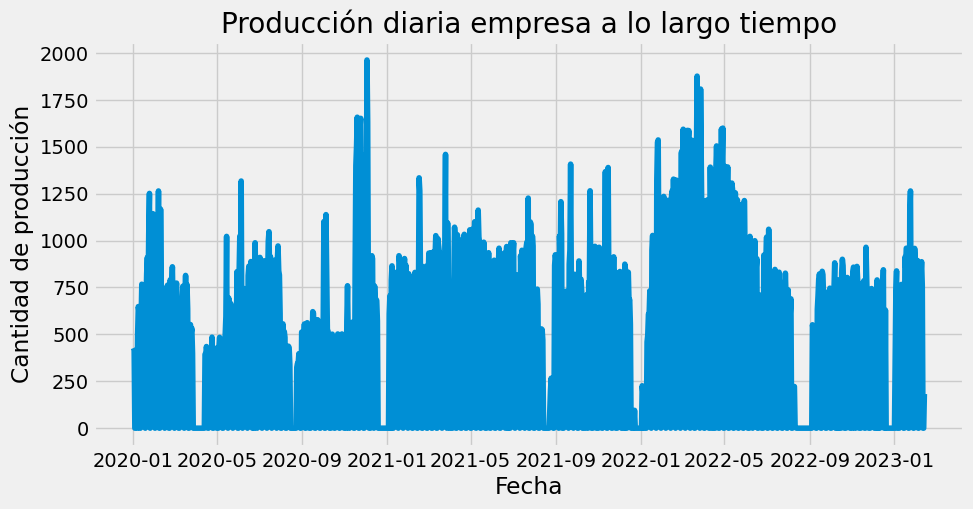

In [20]:
plot_daily_production(df_bombs, 'Producción diaria empresa a lo largo tiempo')

>Gráfico 2: Series temporales de producción a lo largo del tiempo (por día) para el año 2020

C:\Users\Enrique Urrutia\AppData\Local\Temp\ipykernel_13760\2319519605.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_daily = df.resample('D', on='dhIni').sum()


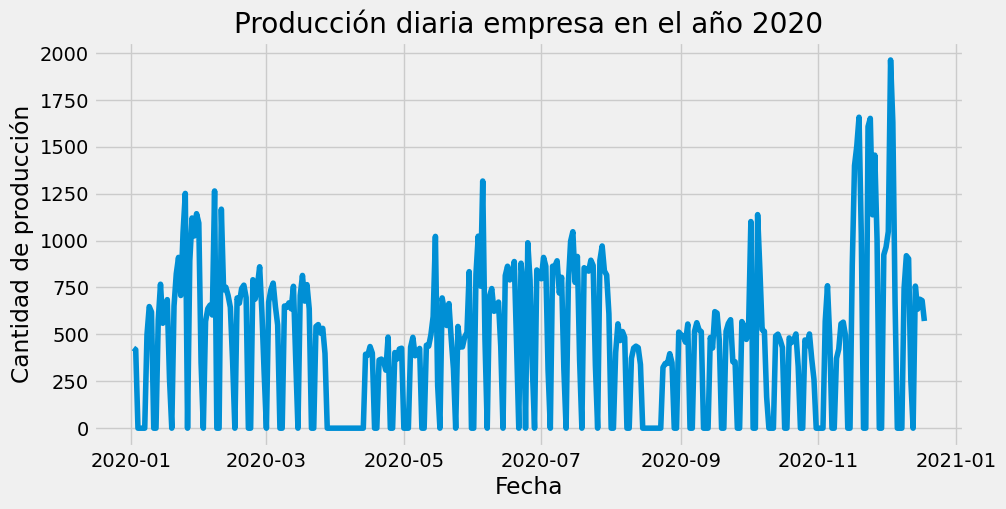

In [21]:
year = 2020
plot_daily_production(df_bombs[df_bombs.dhIni.dt.year == year], f'Producción diaria empresa en el año {year}')

>Gráfico 3: Comparación producción mensual por año

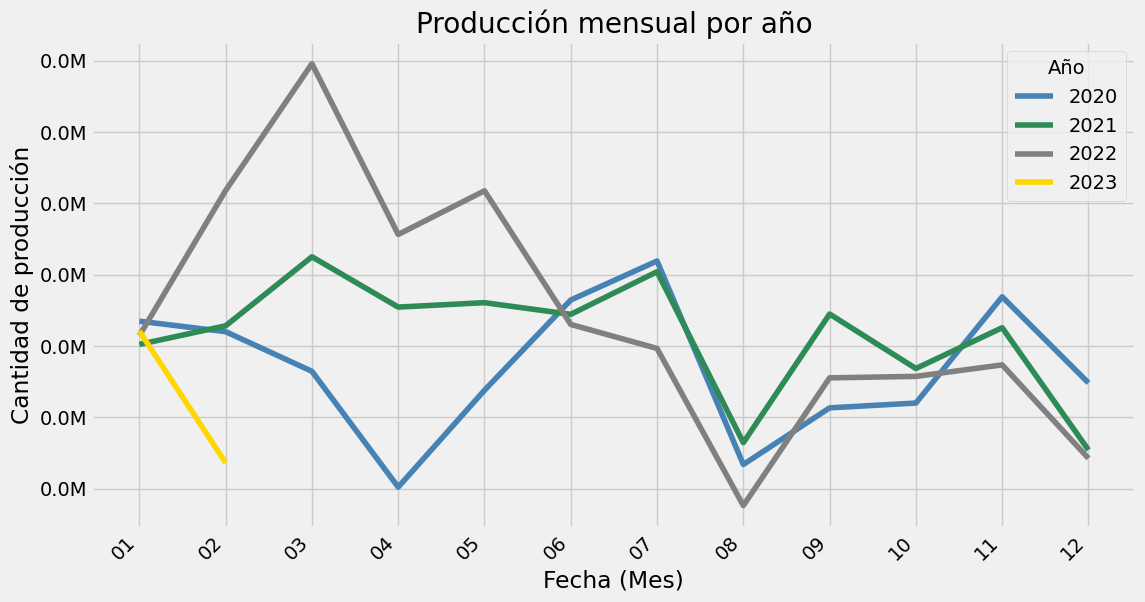

In [25]:
data = df_bombs.copy()
# Crear una columna solo con el mes y el día
data['month'] = data['dhIni'].dt.strftime('%m')

# Agrupar por año, mes y día, y calcular la cantidad de producción diaria
data_daily = data.groupby([data['dhIni'].dt.year, 'month'])['CantidadBuenas'].sum().reset_index()
data_daily.columns = ['year', 'month', 'CantidadBuenas']

# Función para formatear las etiquetas del eje y
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Obtener los años únicos
unique_years = data_daily['year'].unique()

# Colors
color_pal = sns.color_palette(['steelblue', 'seagreen', 'gray', 'gold', 'magenta', 'yellow'])

for i, year in enumerate(unique_years):
    yearly_data = data_daily[data_daily['year'] == year]
    plt.plot(yearly_data['month'], yearly_data['CantidadBuenas'], label=str(int(year)), color=color_pal[i])

plt.xlabel('Fecha (Mes)')
plt.ylabel('Cantidad de producción')
plt.title('Producción mensual por año')

# Aplicar el formateador al eje y
formatter = FuncFormatter(millions_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title='Año')
plt.xticks(rotation=45, ha='right')
plt.show()

#### ¿Cuáles son los materiales más y menos producidos?

In [27]:
df_bombs['CodMaterial'].nunique()

724

Dada la cantidad de materiales, revisaremos los 20 más producidos y los 20 menos producidos

>Gráfico 4: Cantidad producida de los 20 materiales más demandados

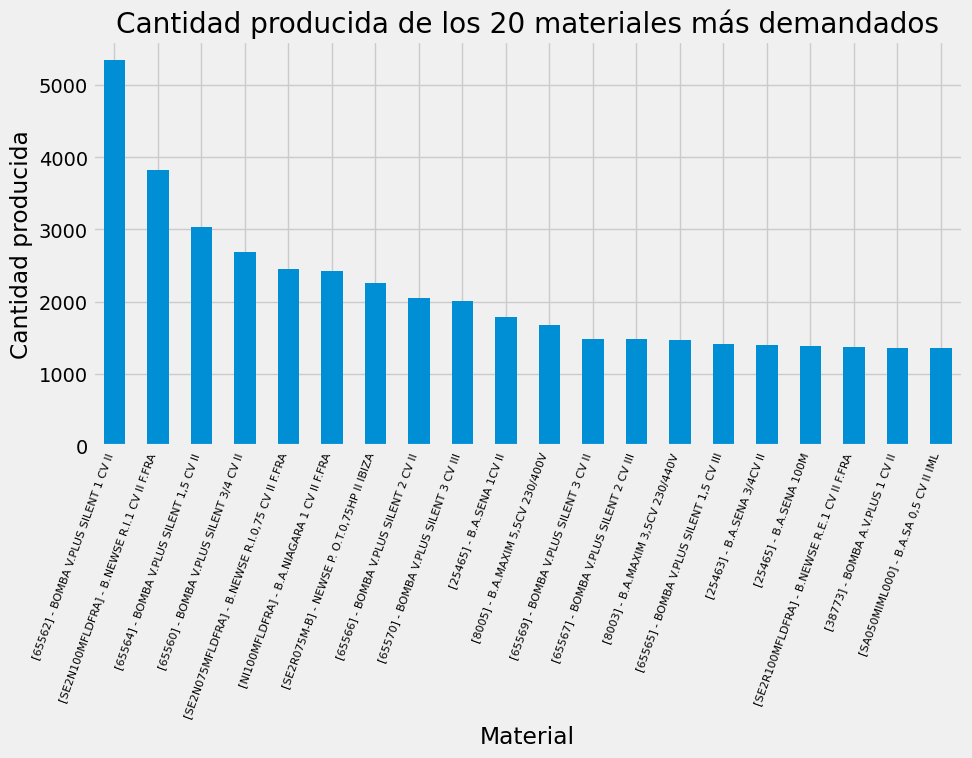

In [40]:
material_counts = df_bombs.groupby(['CodMaterial', 'DescMaterial'])['CantidadBuenas'].size().reset_index(name='count').sort_values(by='count', ascending=False)
material_counts['Cod_Desc'] = '[' + material_counts['CodMaterial'].astype(str) + '] - ' + material_counts['DescMaterial']
material_counts[0:20].plot(kind='bar', x='Cod_Desc', figsize=(10, 5))
plt.xlabel('Material')
plt.ylabel('Cantidad producida')
plt.title('Cantidad producida de los 20 materiales más demandados')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(False)
plt.show()

>Gráfico 4: Cantidad producida de los 20 materiales menos demandados

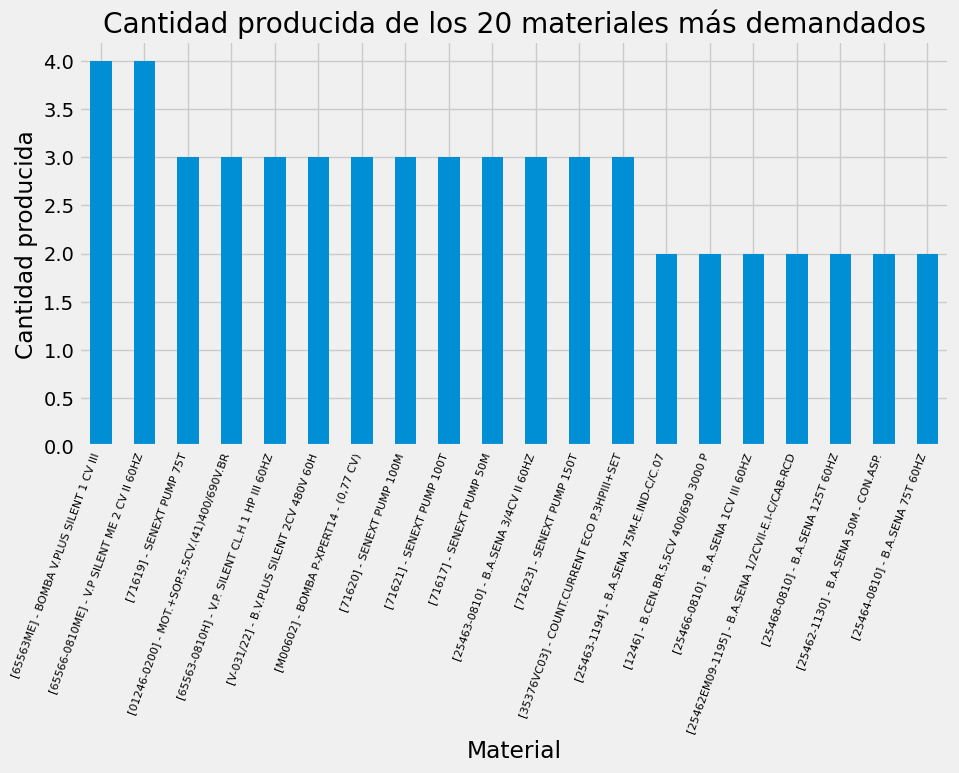

In [38]:
material_counts[-20:].plot(kind='bar', x='Cod_Desc', figsize=(10, 5))
plt.xlabel('Material')
plt.ylabel('Cantidad producida')
plt.title('Cantidad producida de los 20 materiales más demandados')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(False)
plt.show()

#### ¿Cuáles son los materiales más defectuosos?

Dada la cantidad de materiales, revisaremos los 20 más defectuosos y los 20 menos defectuosos
>Se revisa en la data que entre todos los registros, no hay ninguno que tenga QtyMalas_Total y CantidadMalas

#### ¿Cuáles son las máquinas que más y menos producen?

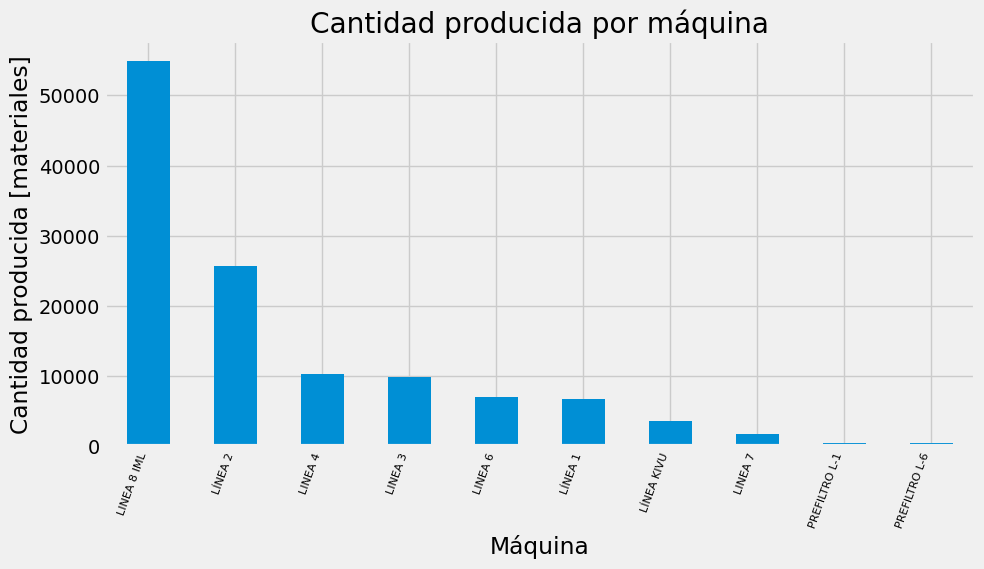

In [43]:
material_counts = df_bombs.groupby(['maquina_dsc'])['CantidadBuenas'].size().reset_index(name='count').sort_values(by='count', ascending=False)
material_counts.plot(kind='bar', x='maquina_dsc', figsize=(10, 5))
plt.xlabel('Máquina')
plt.ylabel('Cantidad producida [materiales]')
plt.title('Cantidad producida por máquina')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.gca().legend().set_visible(False)
plt.show()

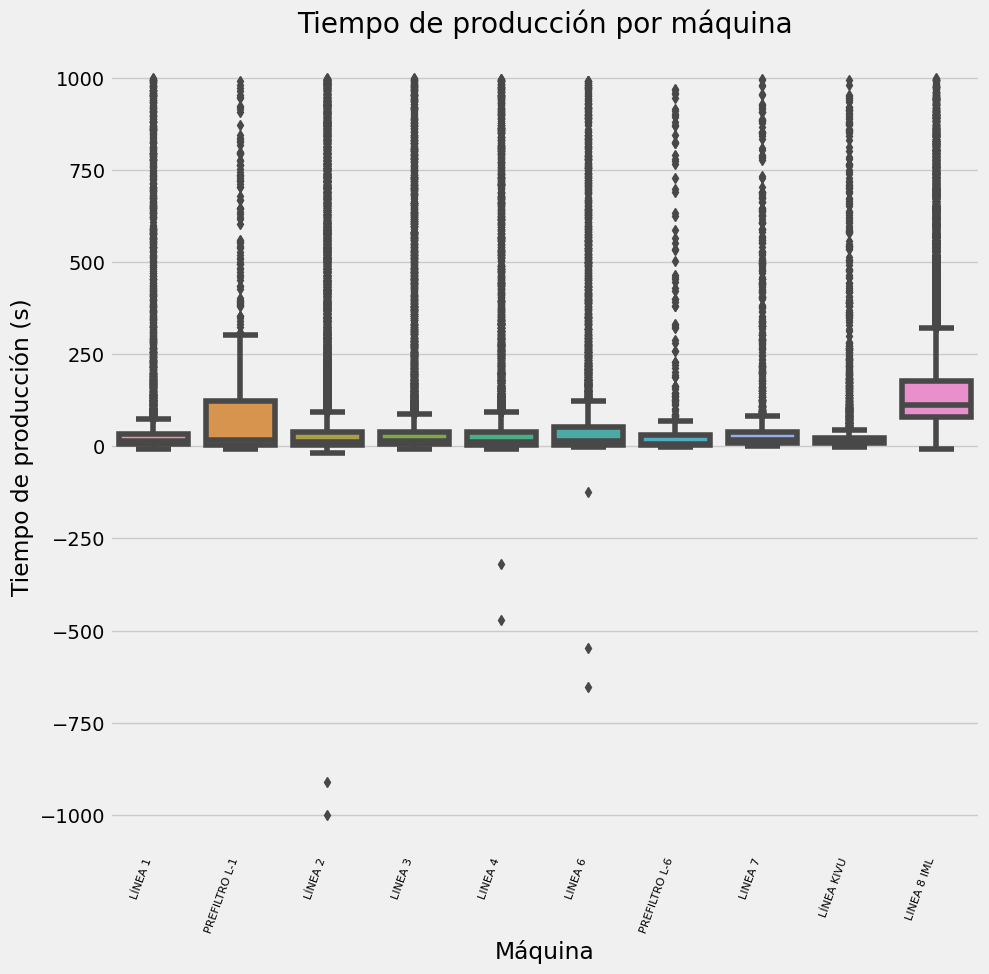

In [45]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df_bombs, x='maquina_dsc', y='T_Diff [s]')
plt.xlabel('Máquina')
plt.ylabel('Tiempo de producción (s)')
plt.title('Tiempo de producción por máquina')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.show()

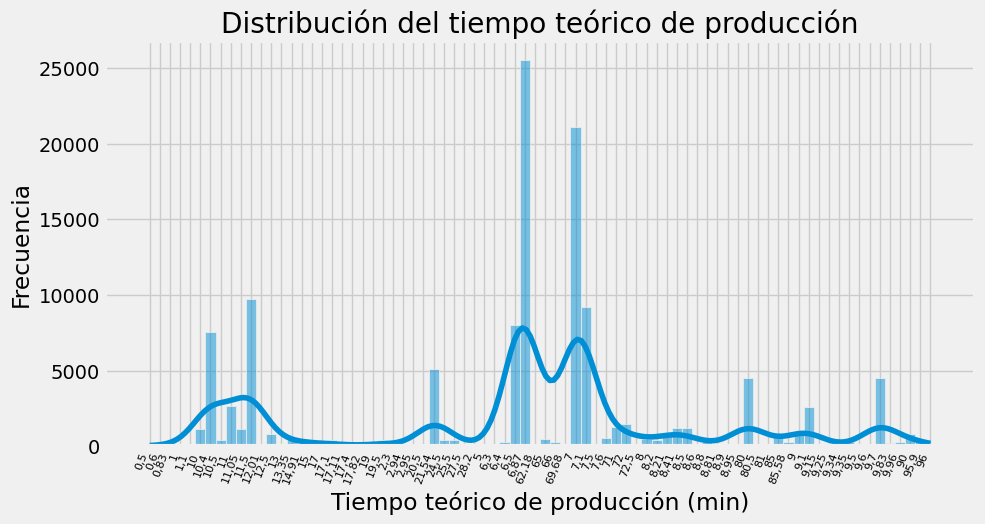

In [48]:
data = df_bombs.sort_values(by='TiempoTeorico [min]')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='TiempoTeorico [min]', bins=20, kde=True)
plt.xlabel('Tiempo teórico de producción (min)')
plt.ylabel('Frecuencia')
plt.title('Distribución del tiempo teórico de producción')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.show()

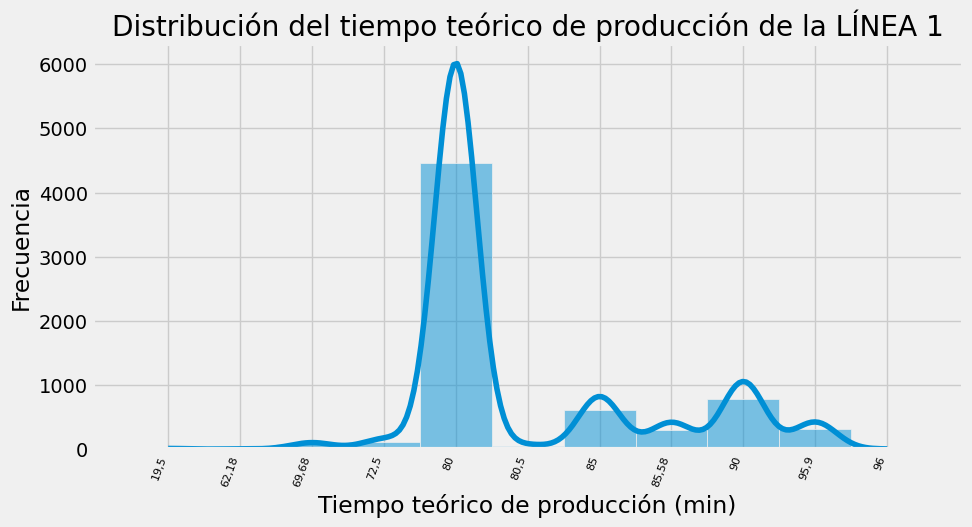

In [52]:
data = df_bombs[df_bombs.maquina_dsc == 'LÍNEA 1'].sort_values(by='TiempoTeorico [min]')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='TiempoTeorico [min]', bins=20, kde=True)
plt.xlabel('Tiempo teórico de producción (min)')
plt.ylabel('Frecuencia')
plt.title('Distribución del tiempo teórico de producción de la LÍNEA 1')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.show()

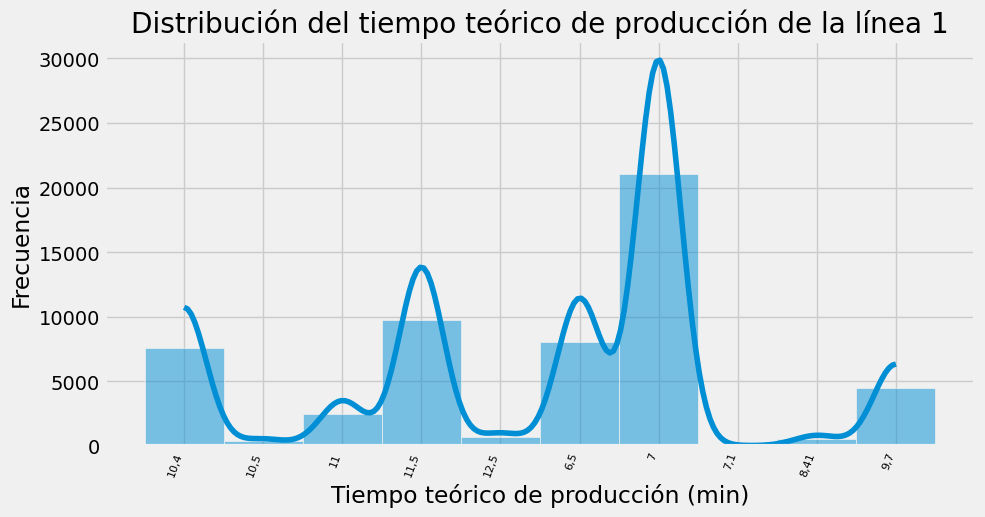

In [51]:
data = df_bombs[df_bombs.maquina_dsc == 'LINEA 8 IML'].sort_values(by='TiempoTeorico [min]')

plt.figure(figsize=(10, 5))
sns.histplot(data=data, x='TiempoTeorico [min]', bins=20, kde=True)
plt.xlabel('Tiempo teórico de producción (min)')
plt.ylabel('Frecuencia')
plt.title('Distribución del tiempo teórico de producción de la LINEA 8 IML')
plt.xticks(rotation=70, ha='right', fontsize=8)
plt.show()